In [1]:
## MLFLOW_TRACKING_URI='https://qualiextra-project-6b29e931dd67.herokuapp.com/'

In [2]:
import pandas as pd
import datetime


In [3]:
data = pd.read_csv("./Missions.csv", sep=';')

In [5]:
from geopy.geocoders import Nominatim
data = pd.read_csv("./Missions.csv", sep=";")
info = pd.read_csv("./hotels.csv", sep=";")
mask = data["hôtel"].notna()
data = data[mask]
data["date_debut"] = data.apply(lambda x: x["date"].split(" →")[0], axis=1)
data["date_debut"] = data["date_debut"].apply(
    lambda x: x.replace(" (UTC+3)", "")
)
data["date_debut"] = data["date_debut"].apply(lambda x: x.replace(" (UTC)", ""))
data["date_debut"] = pd.to_datetime(data["date_debut"], format="%d/%m/%Y %H:%M")
data["time_delta"] = data["nbre d'heures"].apply(lambda x: pd.to_timedelta(x))
data["date_fin"] = data.apply(
    lambda x: x["date_debut"] + x["time_delta"], axis=1
)
data["Propriété"] = data.apply(
    lambda x: x["hôtel"].split(" (")[0] if "www" in x["Propriété"] else x,
    axis=1,
)["Propriété"]
data["Propriété_clean"] = data["hôtel"].apply(lambda x: x.split(" (")[0])
data["extra_clean"] = data["extra"].apply(lambda x: x.split(" (")[0])
data["periode_debut"] = data["date_debut"].dt.strftime("%m-%Y")
data["periode_fin"] = data["date_fin"].dt.strftime("%m-%Y")
data["Année"] = data["date_fin"].dt.year.astype(str)
data["Mois"] = data["date_fin"].dt.to_period("M").astype(str)
data["Semaine"] = data["date_fin"].dt.to_period("W-Mon").astype(str)
data["marge"] = data.apply(lambda x: x["total HT"] - x["montant HT"], axis=1)
data["mois"] = data["date_fin"].dt.strftime("%m")
    

       

In [6]:
# data_prophet = data[['mois', 'extra_clean']]
data["ds"] = pd.to_datetime(data["date_debut"], format="%d/%m/%Y").dt.date 
data_prophet = data.groupby("ds")["extra_clean"].count().to_frame()
data_prophet = data_prophet.rename(columns={'extra_clean':'y'})
data_prophet = data_prophet.reset_index()
data_prophet

,ds,y
0,2021-11-30,1
1,2021-12-01,1
2,2021-12-02,1
3,2021-12-03,4
4,2021-12-04,3
...,...,...
761,2024-01-03,1
762,2024-01-04,2
763,2024-01-05,2
764,2024-01-06,3


In [56]:
data["ds"] = pd.to_datetime(data["date_debut"], format="%d/%m/%Y").dt.date 
data_prophet = data.groupby("ds")["extra_clean"].count().to_frame()
data_prophet = data_prophet.rename(columns={'extra_clean':'y'})
data_ts = data_prophet.reset_index()
data_ts
data_ts['ds'] = data_ts['ds'].apply(lambda x: pd.Timestamp(x))

data_ts['y'] = data_ts['y'].astype('int')



In [57]:
# Split data and declare panel dataset
Y_df = data_ts
Y_df['unique_id'] = 1.

split_date = pd.Timestamp('2023-08-31')
Y_train_df = Y_df[Y_df.ds<= split_date]
# 132 train
Y_test_df = Y_df[Y_df.ds>split_date]# 12 test

In [14]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown
from datetime import datetime
import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS, NHITS, TimesNet
from neuralforecast.utils import AirPassengersDF



# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [NBEATS(input_size=2 * horizon, h=10, max_steps=100),
          NHITS(input_size=2 * horizon, h=10, max_steps=100),
          TimesNet(input_size=2 * horizon, h=10, max_steps=50)]
nf = NeuralForecast(models=models, freq='M')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()



Seed set to 1
Seed set to 1
Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  7.57it/s]


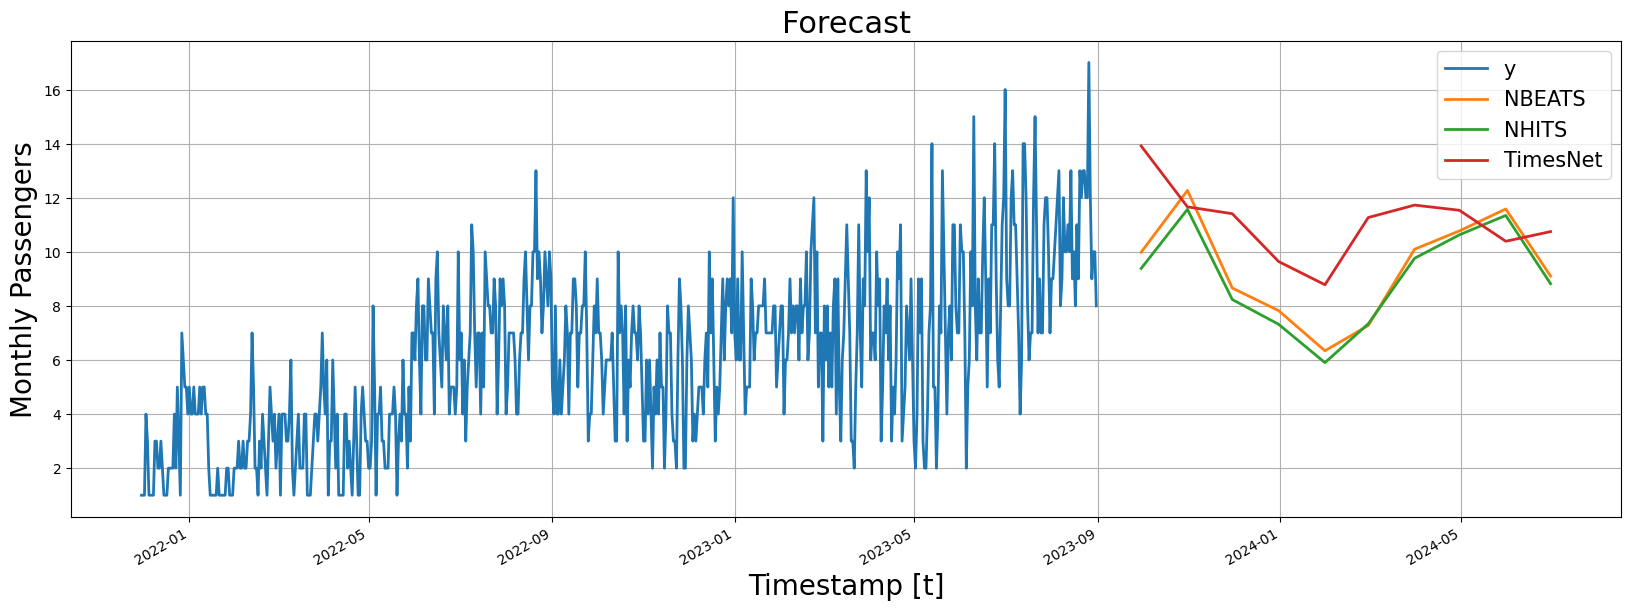

In [15]:
# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df2 = Y_test_df.merge(Y_hat_df, how='outer', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NBEATS', 'NHITS','TimesNet']].plot(ax=ax, linewidth=2)

ax.set_title('Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()


Seed set to 1
Seed set to 1
Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 22.77it/s]


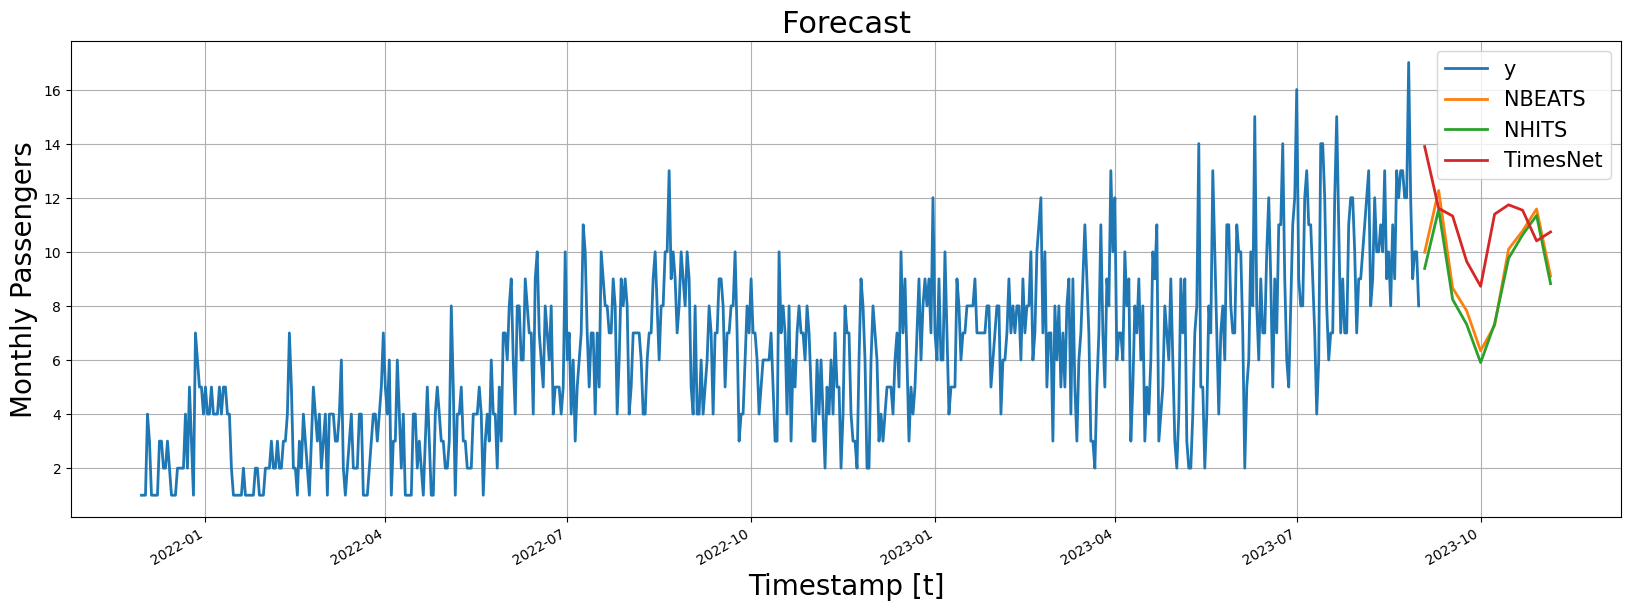

In [16]:
# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [NBEATS(input_size=2 * horizon, h=10, max_steps=100),
          NHITS(input_size=2 * horizon, h=10, max_steps=100),
          TimesNet(input_size=2 * horizon, h=10, max_steps=50)]
nf = NeuralForecast(models=models, freq='W')
nf.fit(df=Y_train_df)
Y_hat_df = nf.predict().reset_index()

# Plot predictions
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
Y_hat_df2 = Y_test_df.merge(Y_hat_df, how='outer', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_train_df, Y_hat_df]).set_index('ds')

plot_df[['y', 'NBEATS', 'NHITS','TimesNet']].plot(ax=ax, linewidth=2)

ax.set_title('Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()

In [30]:
import plotly.express as px
# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [NBEATS(input_size=2 * horizon, h=2*horizon, max_steps=200),
          NBEATS(input_size=2 * horizon, h=2*horizon, max_steps=400),
          NHITS(input_size=2 * horizon, h=2*horizon, max_steps=400),
          TimesNet(input_size=2 * horizon, h=2*horizon, max_steps=100)]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_df, verbose=True,)
nf.save(path='./models/')
Y_hat_df = nf.predict().reset_index()

Y_hat_df2 = Y_test_df.merge(Y_hat_df, how='outer', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds').drop('unique_id', axis=1)



px.line(plot_df)

Seed set to 1
Seed set to 1
Seed set to 1
Seed set to 1


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 17.82it/s]


In [58]:
import plotly.express as px
from neuralforecast.models import NBEATS
# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [
          NBEATS(input_size=2 * horizon, h=horizon, max_steps=785),
        #   NBEATS(input_size=2 * horizon, h=horizon, max_steps=200),
          ]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_df, verbose=True,)
Y_hat_df = nf.predict().reset_index()
nf.save(path='./models/',
        save_dataset=False,
        overwrite=True,)
Y_hat_df2 = Y_test_df.merge(Y_hat_df, how='outer', on=['unique_id', 'ds'])
plot_df = pd.concat([Y_df, Y_hat_df]).set_index('ds').drop('unique_id', axis=1)



px.line(plot_df)

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [9]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px
df = data_ts.copy()
TES = ExponentialSmoothing(df["y"], trend = 'add')
TES_fit = TES.fit()
TES_predict = TES_fit.predict(start=0, end = len(df))

y= df["y"]
MA7 = y.rolling(window=14)
df["y_7"] = round(MA7.mean())
df["y_upper"] = MA7.std()
df["y_lower"] = MA7.std()
df["TES"] = TES_predict
df["max"] = df["TES"] + 1.5*df["y_upper"]
df["min"] = df["TES"] - 1.5*df["y_lower"]   

fig = px.line(x=df["ds"], y=df["y"])
fig.add_trace(px.line(x=df["ds"], y=df["y_7"]).data[0])
fig.add_trace(px.line(x=df["ds"], y=df["max"]).data[0])
fig.add_trace(px.line(x=df["ds"], y=df["min"]).data[0])
fig.add_trace(px.line(x=df["ds"], y=df["TES"]).data[0])
fig['data'][1]['line']['color']="#4BE8E0"
fig['data'][2]['line']['color']="red"
fig['data'][3]['line']['color']="green"
fig['data'][4]['line']['color']="black"
fig.update_layout(hovermode="x unified")
fig.show()

In [79]:
Y1 = df[['ds', 'y']]
Y1['unique_id'] = 'y_hat'
Y2 = df[['ds', 'y_7']].rename(columns={'y_7':'y'})
Y2['unique_id'] = 'y_7'
Y3 = df[['ds', 'TES']].rename(columns={'TES':'y'})
Y3['unique_id'] = 'TES'
Y4 = df[['ds', 'max']].rename(columns={'max':'y'})
Y4['unique_id'] = 'max'
Y5 = df[['ds', 'min']].rename(columns={'min':'y'})
Y5['unique_id'] = 'min'
Y = pd.merge(Y1,Y2, 'outer')
Y = pd.merge(Y,Y3, 'outer')
Y = pd.merge(Y,Y4, 'outer')
Y = pd.merge(Y,Y5, 'outer')
Y = Y[['unique_id', 'ds', 'y']]
Y.sort_values('ds')

,unique_id,ds,y
0,y_hat,2021-11-30,1.000000
1532,TES,2021-11-30,1.725818
3064,min,2021-11-30,NaN
766,y_7,2021-11-30,NaN
2298,max,2021-11-30,NaN
...,...,...,...
3063,max,2024-01-07,6.272435
1531,y_7,2024-01-07,4.000000
765,y_hat,2024-01-07,1.000000
2297,TES,2024-01-07,3.191120


In [80]:
split_date = pd.Timestamp('2023-08-31')
Y_train_df = Y[Y.ds<= split_date]
# 132 train
Y_test_df = Y[Y.ds>split_date]# 12 test

In [98]:
Y5['y'] = Y5['y'].fillna(0)
Y5['y'] = round(Y5['y'], 0).astype('int')
Y5

,ds,y,unique_id
0,2021-11-30,0,min
1,2021-12-01,0,min
2,2021-12-02,0,min
3,2021-12-03,0,min
4,2021-12-04,0,min
...,...,...,...
761,2024-01-03,1,min
762,2024-01-04,1,min
763,2024-01-05,0,min
764,2024-01-06,0,min


In [124]:
import plotly.express as px
from neuralforecast.models import NBEATS
# Fit and predict with NBEATS and NHITS models
Y_hat_df2 = Y_df.drop('unique_id', axis=1).copy()
ts = [Y1, Y2, Y3, Y4, Y5]
for Y in ts:
    Y['y'].fillna(0)
    Y['y'] = round(Y['y'], 0)
    Y['y'] = Y['y'].astype('int')
    split_date = pd.Timestamp('2023-08-31')
    Y_train_df = Y[Y.ds<= split_date]
    # 132 train
    Y_test_df = Y[Y.ds>split_date]#
    horizon = len(Y_test_df)
    models = [
            # NBEATS(input_size=2 * horizon, h=horizon, max_steps=785),
            NBEATS(input_size=2 * horizon, h=horizon, max_steps=200),
            ]
    nf = NeuralForecast(models=models, freq='D')
    nf.fit(df=Y_train_df, verbose=True,)
    Y_hat_df = nf.predict().reset_index().drop('unique_id', axis=1)

    Y_hat_df2 = pd.merge(Y_hat_df2, Y_hat_df, how='outer').rename(columns={'NBEATS': f'{Y["unique_id"].iloc[0]}', 'NBEATS1': f'{Y["unique_id"].iloc[0]}1'})


plot_df = Y_hat_df2.set_index('ds')




Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [126]:
plot_df

,y,y_hat,y_7,TES,max,min
ds,,,,,,
2021-11-30,1.0,NaN,NaN,NaN,NaN,NaN
2021-12-01,1.0,NaN,NaN,NaN,NaN,NaN
2021-12-02,1.0,NaN,NaN,NaN,NaN,NaN
2021-12-03,4.0,NaN,NaN,NaN,NaN,NaN
2021-12-04,3.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-01-04,2.0,11.399722,13.579859,14.355494,19.980745,8.350951
2024-01-05,2.0,12.195201,13.626298,14.232773,18.577358,7.922435
2024-01-06,3.0,12.866854,13.886091,14.637093,19.081423,8.290671


In [127]:
px.line(plot_df)

In [46]:
import ray
ray.shutdown()
# ray.init()

In [22]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import plotly.express as px
from neuralforecast.auto import AutoNBEATS
from neuralforecast.losses.pytorch import MQLoss, MSE
from neuralforecast import NeuralForecast
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
# Fit and predict with NBEATS and NHITS models
horizon = len(Y_test_df)
models = [AutoNBEATS(h=2*horizon, search_alg=HyperOptSearch(), num_samples=25)]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=Y_train_df)
nf.save(path='./models/',
        save_dataset=False,
        overwrite=True,)
fcst_df = nf.predict().reset_index()
fcst_df.columns = fcst_df.columns.str.replace('-median', '')




(_train_tune pid=30051) Seed set to 13
2023-12-01 14:43:29,249	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_e44a04e1
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/pytho

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-12-01 14:43:33,620	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_e0817c43
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/worker

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(_train_tune pid=30133) Seed set to 14 [repeated 2x across cluster]


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 87.50it/s, v_num=0, train_loss_step=0.0205, train_loss_epoch=0.0224] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 80.95it/s, v_num=0, train_loss_step=0.00893, train_loss_epoch=0.0082, valid_loss=3.430]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 73.79it/s, v_num=0, train_loss_step=0.0112, train_loss_epoch=0.0105, valid_loss=3.440]   
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 68.90it/s, v_num=0, train_loss_step=0.00528, train_loss_epoch=0.00545, valid_loss=3.440]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 491:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00461, train_loss_epoch=0.00461, valid_loss=3.450]         


2023-12-01 14:43:45,474	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 73.43it/s, v_num=0, train_loss_step=0.00476, train_loss_epoch=0.00539, valid_loss=3.450] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 41.52it/s, v_num=0, train_loss_step=0.00476, train_loss_epoch=0.00476, valid_loss=3.450]


(_train_tune pid=30133) Seed set to 10
2023-12-01 14:43:45,685	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_d15fd0f5
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/pytho

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                              


(_train_tune pid=30185) Seed set to 12
2023-12-01 14:43:50,185	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_068602ea
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/pytho

Sanity Checking: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-12-01 14:43:54,611	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_7f2ff8e8
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/worker

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(_train_tune pid=30268) Seed set to 6 [repeated 2x across cluster]
2023-12-01 14:43:59,294	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_717cfdc4
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiex

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 48.57it/s, v_num=0, train_loss_step=2.86e+8, train_loss_epoch=2.84e+8]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 49.25it/s, v_num=0, train_loss_step=7.27e+7, train_loss_epoch=8.16e+7, valid_loss=1.41e+9]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 49.11it/s, v_num=0, train_loss_step=7.27e+6, train_loss_epoch=2.23e+7, valid_loss=1.96e+9]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 41.93it/s, v_num=0, train_loss_step=1.5e+7, train_loss_epoch=1.14e+7, valid_loss=3.62e+8] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 39.18it/s, v_num=0, train_loss_step=2.45e+6, train_loss_epoch=5.45e+6, valid_loss=4.33e+8]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 1/1 [00:00<00:00, 38.62it/s, v_num=0, train_loss_step=4.91e+6, train_loss_epoc

2023-12-01 14:44:27,889	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 998:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=6.5e+6, train_loss_epoch=6.5e+6, valid_loss=3.63e+8]          


(_train_tune pid=30307) Seed set to 13 [repeated 2x across cluster]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 41.82it/s, v_num=0, train_loss_step=4.32e+6, train_loss_epoch=8.37e+6, valid_loss=3.63e+8]
Validation: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-12-01 14:44:28,500	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_bfa07ea9
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/worker

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


2023-12-01 14:44:33,472	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_fc46898c
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/worker

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(_train_tune pid=30398) Seed set to 7 [repeated 2x across cluster]


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 75.54it/s, v_num=0, train_loss_step=0.0355, train_loss_epoch=0.0425] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 71.53it/s, v_num=0, train_loss_step=0.0197, train_loss_epoch=0.024, valid_loss=3.320] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 69.44it/s, v_num=0, train_loss_step=0.0179, train_loss_epoch=0.0294, valid_loss=3.360]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 64.63it/s, v_num=0, train_loss_step=0.00819, train_loss_epoch=0.00974, valid_loss=3.380]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 488:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.00777, train_loss_epoch=0.00777, valid_loss=3.380]        


2023-12-01 14:44:46,743	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 66.00it/s, v_num=0, train_loss_step=0.00801, train_loss_epoch=0.0114, valid_loss=3.380] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 35.53it/s, v_num=0, train_loss_step=0.00801, train_loss_epoch=0.00801, valid_loss=3.380]


(_train_tune pid=30398) Seed set to 9
2023-12-01 14:44:46,958	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_15288e6e
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                              


(_train_tune pid=30448) Seed set to 8


Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  9.19it/s]


2023-12-01 14:44:51,801	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_53ad7043
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/worker

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 98.32it/s, v_num=0, train_loss_step=1.01e+12, train_loss_epoch=1.31e+12] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 103.16it/s, v_num=0, train_loss_step=5.81e+5, train_loss_epoch=6.76e+5, valid_loss=1.16e+11]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=30486) 
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 99.82it/s, v_num=0, train_loss_step=1.36e+4, train_loss_epoch=3.12e+4, valid_loss=1.55e+6] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 89.53it/s, v_num=0, train_loss_step=1.05e+3, train_loss_epoch=1.03e+3, valid_loss=1.74e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 103.98it/s, v_num=0, train_loss_step=1.24e+3, train_loss_epoch=1.38e+3, valid_loss=1.51e+5]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation 

2023-12-01 14:45:07,803	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}
(_train_tune pid=30486) Seed set to 12 [repeated 2x across cluster]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 98.47it/s, v_num=0, train_loss_step=822.0, train_loss_epoch=834.0, valid_loss=1.37e+5] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 44.59it/s, v_num=0, train_loss_step=822.0, train_loss_epoch=822.0, valid_loss=1.34e+5]


2023-12-01 14:45:08,021	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_24ce33cd
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/worker

Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 66.13it/s, v_num=0, train_loss_step=0.0671, train_loss_epoch=0.0572]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 74.22it/s, v_num=0, train_loss_step=0.0389, train_loss_epoch=0.0409, valid_loss=2.680] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 65.61it/s, v_num=0, train_loss_step=0.0356, train_loss_epoch=0.0336, valid_loss=2.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 65.58it/s, v_num=0, train_loss_step=0.0179, train_loss_epoch=0.0198, valid_loss=2.640]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]
(_train_tune pid=30538) 
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 64.84it/s, v_num=0, train_loss_step=0.0173, train_loss_epoch=0.0149, valid_loss=2.630]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|█████

2023-12-01 14:45:30,032	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 62.19it/s, v_num=0, train_loss_step=0.00791, train_loss_epoch=0.00909, valid_loss=2.640]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 31.95it/s, v_num=0, train_loss_step=0.00791, train_loss_epoch=0.00791, valid_loss=2.640]


(_train_tune pid=30538) Seed set to 7 [repeated 2x across cluster]
2023-12-01 14:45:30,249	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_99dc7860
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiex

Sanity Checking DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 129.92it/s]
                                                                            
Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 46.66it/s, v_num=0, train_loss_step=0.143, train_loss_epoch=0.126]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 43.66it/s, v_num=0, train_loss_step=0.0856, train_loss_epoch=0.156, valid_loss=11.80]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 46.12it/s, v_num=0, train_loss_step=0.098, train_loss_epoch=0.0817, valid_loss=14.80] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 49.05it/s, v_num=0, train_loss_step=0.0492, train_loss_epoch=0.0273, valid_loss=16.40]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 44.11it/s, v_num=0, train_loss_step=0.0449, train_loss_epoch=0.0483, valid_loss=18.50]
Validation: |      

2023-12-01 14:45:58,953	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999:   0%|          | 0/1 [00:00<?, ?it/s, v_num=0, train_loss_step=0.0243, train_loss_epoch=0.0243, valid_loss=20.90]        


(_train_tune pid=30594) Seed set to 13 [repeated 2x across cluster]


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 48.37it/s, v_num=0, train_loss_step=0.0356, train_loss_epoch=0.0243, valid_loss=20.90]
Validation: |          | 0/? [00:00<?, ?it/s]
Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-12-01 14:45:59,771	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_f7c83ef6
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/worker

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(_train_tune pid=30762) Seed set to 10


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 134.48it/s, v_num=0, train_loss_step=0.363, train_loss_epoch=0.329]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 199: 100%|██████████| 1/1 [00:00<00:00, 128.45it/s, v_num=0, train_loss_step=0.158, train_loss_epoch=0.163, valid_loss=2.900]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 299: 100%|██████████| 1/1 [00:00<00:00, 142.51it/s, v_num=0, train_loss_step=0.137, train_loss_epoch=0.151, valid_loss=2.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Validation DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 240.54it/s]
(_train_tune pid=30762) 
Epoch 399: 100%|██████████| 1/1 [00:00<00:00, 130.55it/s, v_num=0, train_loss_step=0.078, train_loss_epoch=0.0764, valid_loss=2.950] 
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 139.10it/s, v_num=0, train_loss_step=0.0805, train_loss_epoch=0.0794, valid_loss=2.980]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 599: 100%|██████████| 

2023-12-01 14:46:15,295	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'loss': ('__ref_ph', 'de895953'), 'valid_loss': ('__ref_ph', '004b9a7a')}


Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 101.86it/s, v_num=0, train_loss_step=0.0438, train_loss_epoch=0.0433, valid_loss=2.940]
Validation: |          | 0/? [00:00<?, ?it/s]
Epoch 999: 100%|██████████| 1/1 [00:00<00:00, 46.64it/s, v_num=0, train_loss_step=0.0438, train_loss_epoch=0.0438, valid_loss=2.940] 


(_train_tune pid=30762) Seed set to 10
2023-12-01 14:46:15,513	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_535467e3
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/pytho

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


2023-12-01 14:46:21,305	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_92dee809
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/worker

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


(_train_tune pid=30854) Seed set to 6 [repeated 2x across cluster]
2023-12-01 14:46:25,782	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_0a5a612d
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiex

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]                             


2023-12-01 14:46:30,931	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_a599f6f1
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/worker

Epoch 0:   0%|          | 0/1 [00:00<?, ?it/s]


(_train_tune pid=30940) Seed set to 7 [repeated 2x across cluster]
2023-12-01 14:46:35,586	ERROR tune_controller.py:1383 -- Trial task failed for trial _train_tune_5f5b9950
Traceback (most recent call last):
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
             ^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/auto_init_hook.py", line 24, in auto_init_wrapper
    return fn(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiextra/.qualiextraenv/lib/python3.11/site-packages/ray/_private/client_mode_hook.py", line 103, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "/home/adrien/Documents/Jedha_Projects/final_project/Qualiex

Sanity Checking DataLoader 0:   0%|          | 0/1 [00:00<?, ?it/s]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

In [23]:
fcst_df

,unique_id,ds,AutoNBEATS
0,1.0,2023-09-01,7.041397
1,1.0,2023-09-02,6.927591
2,1.0,2023-09-03,3.754251
3,1.0,2023-09-04,5.803445
4,1.0,2023-09-05,6.421183
...,...,...,...
251,1.0,2024-05-09,5.397895
252,1.0,2024-05-10,4.792198
253,1.0,2024-05-11,3.197878
254,1.0,2024-05-12,8.386724


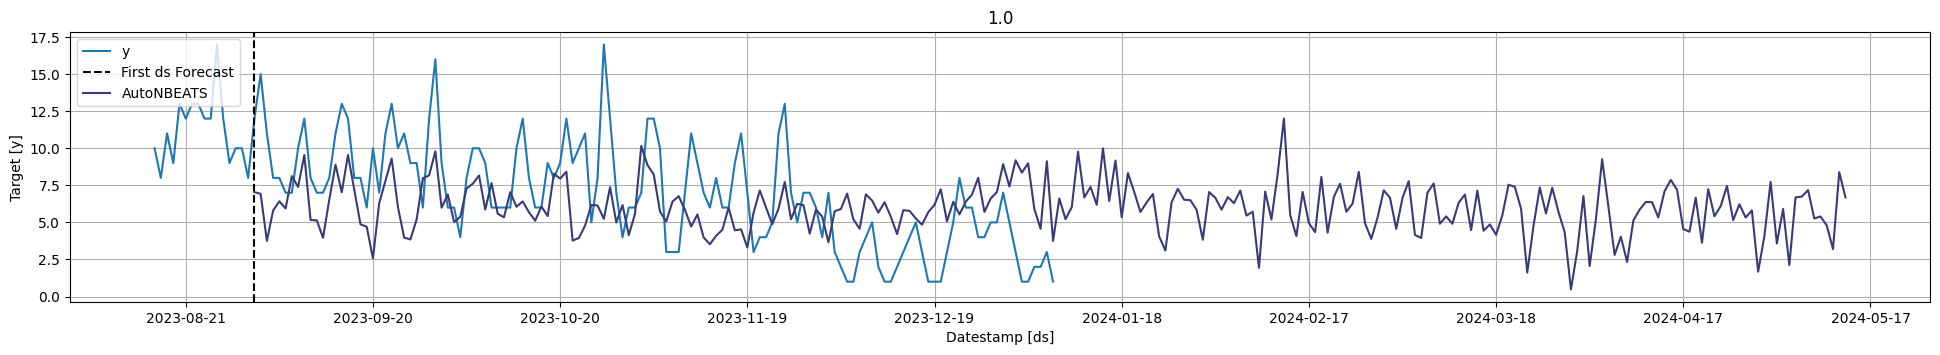

In [24]:
from statsforecast import StatsForecast
StatsForecast.plot(Y_df, fcst_df, engine='matplotlib', max_insample_length=48 * 3, level=[80, 90])

In [26]:
plot_df = pd.concat([Y_df, fcst_df]).set_index('ds').drop('unique_id', axis=1)
px.line(plot_df)


In [82]:
Y_hat_df.sort_values('ds')

,unique_id,ds,NBEATS
0,TES,2023-09-01,NaN
480,y_7,2023-09-01,NaN
120,max,2023-09-01,NaN
240,min,2023-09-01,NaN
360,y,2023-09-01,NaN
...,...,...,...
479,y,2023-12-29,NaN
239,max,2023-12-29,NaN
119,TES,2023-12-29,NaN
359,min,2023-12-29,NaN


In [26]:
cv = nf.cross_validation(Y_train_df)

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 238.50it/s]


In [29]:
from datasetsforecast.losses import mse, mae, rmse
from datasetsforecast.evaluation import accuracy

evaluation_df = accuracy(cv, [mse, mae, rmse], agg_by=['unique_id'])
evaluation_df['best_model'] = evaluation_df.drop(columns=['metric', 'unique_id']).idxmin(axis=1)
evaluation_df.head()

_1 _State.RUNNING -> _State.FAILED  Invalid syntax: 'unique_id:double,metric:string,cutoff:timestamp[us],NBEATS:double' Expecting ',' delimiter: line 1 column 61 (char 60)


SchemaError: Invalid syntax: 'unique_id:double,metric:string,cutoff:timestamp[us],NBEATS:double' Expecting ',' delimiter: line 1 column 61 (char 60)

In [19]:
data.groupby("Propriété_clean")["extra_clean"].unique().apply(lambda x: len(x))

Propriété_clean
Alberte                 3
Apogé                  12
Bleu de Grenelle        4
Chouchou                5
Courseine              17
Crystal                10
Drawing House          12
Edouard VI              7
French Theory          17
Home Moderne            2
Ibis Montparnasse      30
Imprimerie             44
La Belle Ville         11
Le Grand Quartier      37
Le Roch Hotel           1
Les Deux Girafes       10
MT solutions            2
Marceau                 6
Mathurin                2
Milie Rose             19
Mont Dore               1
Monte Cristo           17
Parisianer             11
Parisis                 7
Peper and paper         1
Prélude                18
Quinzerie hotel         5
Select Hotel           22
Touraine               12
Tsuba                  11
Victoire et Germain    14
Yllen Eiffel           16
Name: extra_clean, dtype: int64

In [20]:
from geopy.geocoders import BANFrance

info["Adresse"] = (
info["adresse"]
+ " "
+ info["code"].astype("str")
+ " "
+ info["ville"]
)
hotel = pd.DataFrame(data['Propriété_clean'].unique(), columns=['nom'])
hotel = pd.merge(hotel, info[['nom', 'Adresse']], on= 'nom', how='outer')
hotel['Adresse']=hotel['Adresse'].fillna('Paris')
geolocator = BANFrance()
hotel['location'] = hotel['Adresse'].apply(geolocator.geocode)
hotel['latitude'] = hotel['location'].apply(lambda loc: tuple(loc.point)[0] if loc else None)
hotel['longitude'] = hotel['location'].apply(lambda loc: tuple(loc.point)[1] if loc else None)
hotel["total_extras"] = (
        data.groupby("Propriété_clean")["extra_clean"].unique().apply(lambda x: len(x))
    )
hotel

,nom,Adresse,location,latitude,longitude,total_extras
0,Crystal,24 rue Saint-Benoît 75006 Paris,"(24 Rue Saint-Benoît 75006 Paris, (48.854373, ...",48.854373,2.332735,NaN
1,Milie Rose,22 rue des Petites-Écuries 75010 Paris,"(22 Rue des Petites Ecuries 75010 Paris, (48.8...",48.873652,2.352020,NaN
2,Touraine,73 rue Taitbout 75009 Paris,"(73 Rue Taitbout 75009 Paris, (48.876362, 2.33...",48.876362,2.335302,NaN
3,Ibis Montparnasse,160 rue du Château 75014 Paris,"(160 Rue du Château 75014 Paris, (48.833754, 2...",48.833754,2.322979,NaN
4,Chouchou,11 rue du Helder 75009 Paris,"(11 Rue du Helder 75009 Paris, (48.872037, 2.3...",48.872037,2.334908,NaN
5,Courseine,18 avenue Marceau 92400 Courbevoie,"(18 Avenue Marceau 92400 Courbevoie, (48.89890...",48.898905,2.246507,NaN
6,Imprimerie,15 rue Victor-Méric 92110 Clichy,"(15 Rue Victor Méric 92110 Clichy, (48.901497,...",48.901497,2.305941,NaN
7,Yllen Eiffel,196 rue de Vaugirard 75015 Paris,"(196 Rue de Vaugirard 75015 Paris, (48.841507,...",48.841507,2.307722,NaN
8,Drawing House,21 rue Vercingétorix 75014 Paris,"(21 Rue Vercingétorix 75014 Paris, (48.83735, ...",48.837350,2.319941,NaN
9,Le Grand Quartier,15 rue de Nancy 75010 Paris,"(15 Rue de Nancy 75010 Paris, (48.872329, 2.35...",48.872329,2.358432,NaN


In [21]:
pd.merge(hotel, data.groupby("Propriété_clean")["extra_clean"].unique().apply(lambda x: len(x)).to_frame(), left_on='nom', right_on='Propriété_clean')

,nom,Adresse,location,latitude,longitude,total_extras,extra_clean
0,Crystal,24 rue Saint-Benoît 75006 Paris,"(24 Rue Saint-Benoît 75006 Paris, (48.854373, ...",48.854373,2.332735,NaN,10
1,Milie Rose,22 rue des Petites-Écuries 75010 Paris,"(22 Rue des Petites Ecuries 75010 Paris, (48.8...",48.873652,2.352020,NaN,19
2,Touraine,73 rue Taitbout 75009 Paris,"(73 Rue Taitbout 75009 Paris, (48.876362, 2.33...",48.876362,2.335302,NaN,12
3,Ibis Montparnasse,160 rue du Château 75014 Paris,"(160 Rue du Château 75014 Paris, (48.833754, 2...",48.833754,2.322979,NaN,30
4,Chouchou,11 rue du Helder 75009 Paris,"(11 Rue du Helder 75009 Paris, (48.872037, 2.3...",48.872037,2.334908,NaN,5
5,Courseine,18 avenue Marceau 92400 Courbevoie,"(18 Avenue Marceau 92400 Courbevoie, (48.89890...",48.898905,2.246507,NaN,17
6,Imprimerie,15 rue Victor-Méric 92110 Clichy,"(15 Rue Victor Méric 92110 Clichy, (48.901497,...",48.901497,2.305941,NaN,44
7,Yllen Eiffel,196 rue de Vaugirard 75015 Paris,"(196 Rue de Vaugirard 75015 Paris, (48.841507,...",48.841507,2.307722,NaN,16
8,Drawing House,21 rue Vercingétorix 75014 Paris,"(21 Rue Vercingétorix 75014 Paris, (48.83735, ...",48.837350,2.319941,NaN,12
9,Le Grand Quartier,15 rue de Nancy 75010 Paris,"(15 Rue de Nancy 75010 Paris, (48.872329, 2.35...",48.872329,2.358432,NaN,37


In [22]:
def load_data():
    data = pd.read_csv("./Missions.csv", sep=";")
    info = pd.read_csv("./hotels.csv", sep=";")
    mask = data["hôtel"].notna()
    data = data[mask]
    data["date_debut"] = data.apply(lambda x: x["date"].split(" →")[0], axis=1)
    data["date_debut"] = data["date_debut"].apply(
        lambda x: x.replace(" (UTC+3)", "")
    )
    data["date_debut"] = data["date_debut"].apply(lambda x: x.replace(" (UTC)", ""))
    data["date_debut"] = pd.to_datetime(data["date_debut"], format="%d/%m/%Y %H:%M")
    data["time_delta"] = data["nbre d'heures"].apply(lambda x: pd.to_timedelta(x))
    data["date_fin"] = data.apply(
        lambda x: x["date_debut"] + x["time_delta"], axis=1
    )
    data["Propriété"] = data.apply(
        lambda x: x["hôtel"].split(" (")[0] if "www" in x["Propriété"] else x,
        axis=1,
    )["Propriété"]
    data["Propriété_clean"] = data["hôtel"].apply(lambda x: x.split(" (")[0])
    data["extra_clean"] = data["extra"].apply(lambda x: x.split(" (")[0])
    data["periode_debut"] = data["date_debut"].dt.strftime("%m-%Y")
    data["periode_fin"] = data["date_fin"].dt.strftime("%m-%Y")
    data["Année"] = data["date_fin"].dt.year.astype(str)
    data["Mois"] = data["date_fin"].dt.to_period("M").astype(str)
    data["Semaine"] = data["date_fin"].dt.to_period("W-Mon").astype(str)
    data["marge"] = data.apply(lambda x: x["total HT"] - x["montant HT"], axis=1)
    data["mois"] = data["date_fin"].dt.strftime("%m")
    info["Adresse"] = (
        info["adresse"].iloc[0]
        + " "
        + info["code"].iloc[0].astype("str")
        + " "
        + info["ville"].iloc[0]
    )
    hotel = pd.DataFrame(data["Propriété_clean"].unique(), columns=["nom"])
    hotel = pd.merge(hotel, info[["nom", "Adresse"]], on="nom", how="outer")
    hotel["Adresse"] = hotel["Adresse"].fillna("Paris")
    geolocator = BANFrance()
    hotel["location"] = hotel["Adresse"].apply(geolocator.geocode)
    hotel["latitude"] = hotel["location"].apply(
        lambda loc: tuple(loc.point)[0] if loc else None
    )
    hotel["longitude"] = hotel["location"].apply(
        lambda loc: tuple(loc.point)[1] if loc else None
    )
    data["latitude"] = data["Propriété_clean"].apply(
        lambda x: hotel[hotel["nom"] == x]["latitude"].iloc[0]
    )
    data["longitude"] = data["Propriété_clean"].apply(
        lambda x: hotel[hotel["nom"] == x]["longitude"].iloc[0]
    )

    return data

load_data()

,Propriété,hôtel,extra,date,statuts,tarif urgence,tarif horaire,nbre d'heures,total HT,facture,...,extra_clean,periode_debut,periode_fin,Année,Mois,Semaine,marge,mois,latitude,longitude
0,Crystal,Crystal (https://www.notion.so/Crystal-1837fcb...,Grégory Tshimini (https://www.notion.so/Gr-gor...,07/01/2024 8:00 → 20:00,NaN,NaN,21.0,12hr 0min,252,NaN,...,Grégory Tshimini,01-2024,01-2024,2024,2024-01,2024-01-02/2024-01-08,72,01,48.8549,2.305102
1,Milie rose,Milie Rose (https://www.notion.so/Milie-Rose-0...,Mamadou Koma (https://www.notion.so/Mamadou-Ko...,06/01/2024 22:30 → 07/01/2024 8:00,NaN,NaN,20.0,9hr 30min,180,NaN,...,Mamadou Koma,01-2024,01-2024,2024,2024-01,2024-01-02/2024-01-08,45,01,48.8549,2.305102
2,Touraine,Touraine (https://www.notion.so/Touraine-df4e7...,Mohamed Belbachir (https://www.notion.so/Moham...,06/01/2024 19:30 → 07/01/2024 7:30,NaN,NaN,20.0,12hr 0min,240,NaN,...,Mohamed Belbachir,01-2024,01-2024,2024,2024-01,2024-01-02/2024-01-08,60,01,48.8549,2.305102
3,Crystal,Crystal (https://www.notion.so/Crystal-1837fcb...,Grégory Tshimini (https://www.notion.so/Gr-gor...,06/01/2024 8:00 → 20:00,NaN,NaN,21.0,12hr 0min,252,NaN,...,Grégory Tshimini,01-2024,01-2024,2024,2024-01,2024-01-02/2024-01-08,72,01,48.8549,2.305102
4,Milie rose,Milie Rose (https://www.notion.so/Milie-Rose-0...,Mamadou Koma (https://www.notion.so/Mamadou-Ko...,05/01/2024 22:30 → 06/01/2024 8:00,NaN,NaN,20.0,9hr 30min,180,NaN,...,Mamadou Koma,01-2024,01-2024,2024,2024-01,2024-01-02/2024-01-08,45,01,48.8549,2.305102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4765,Courseine,Courseine (https://www.notion.so/Courseine-08e...,Mohamed Belbachir (https://www.notion.so/Moham...,03/12/2021 14:30 → 19:30,NaN,NaN,20.0,5hr 0min,100,NaN,...,Mohamed Belbachir,12-2021,12-2021,2021,2021-12,2021-11-30/2021-12-06,25,12,48.8549,2.305102
4766,Prélude,Prélude (https://www.notion.so/Pr-lude-8f471c1...,Valentin Tempez (https://www.notion.so/Valenti...,03/12/2021 7:00 → 15:00,NaN,NaN,20.0,8hr 0min,160,NaN,...,Valentin Tempez,12-2021,12-2021,2021,2021-12,2021-11-30/2021-12-06,40,12,48.8549,2.305102
4767,Tsuba,Tsuba (https://www.notion.so/Tsuba-6ee550393da...,Yves Constant (https://www.notion.so/Yves-Cons...,02/12/2021 22:30 → 03/12/2021 7:15,NaN,NaN,20.0,8hr 45min,160,NaN,...,Yves Constant,12-2021,12-2021,2021,2021-12,2021-11-30/2021-12-06,40,12,48.8549,2.305102
4768,Prélude,Prélude (https://www.notion.so/Pr-lude-8f471c1...,Sorel Pambou (https://www.notion.so/Sorel-Pamb...,01/12/2021 12:30 → 21:00,NaN,NaN,20.0,8hr 30min,160,NaN,...,Sorel Pambou,12-2021,12-2021,2021,2021-12,2021-11-30/2021-12-06,40,12,48.8549,2.305102


In [23]:
info["Adresse"] = (
     info['adresse'] + ' ' + info['code'].astype('str') + ' '+ info['ville']
)
geolocator = Nominatim(user_agent="geoapiEx")
info['location'] = info['Adresse'].apply(geolocator.geocode)
info['latitude'] = info['location'].apply(lambda loc: tuple(loc.point)[0] if loc else None)
info['longitude'] = info['location'].apply(lambda loc: tuple(loc.point)[1] if loc else None)
data["latitude"] = data["Propriété_clean"].apply(
            lambda x: info[info["nom"] == x]["latitude"].iloc[0] if info[info["nom"] == x]["latitude"].to_list != [] else None
            
        )
data["longitude"] = data["Propriété_clean"].apply(
    lambda x: info[info["nom"] == x]["longitude"].iloc[0])

IndexError: single positional indexer is out-of-bounds

In [ ]:
set(data['Propriété_clean'].unique()).difference(set(info['nom'].unique()))

: 

In [ ]:
data[data['Propriété_clean']== 'Home Moderne']

: 

In [ ]:
info[info["nom"] == 'Home Moderne']["latitude"].to_list()

: 

In [ ]:
data[data["Année"] == "2023"].groupby("Mois")["extra_clean"].unique().count()

: 

In [ ]:
data[data["Année"] == "2023"].groupby("Mois").count()

: 

In [ ]:
fig = go.Figure()

for period in data["Année"].unique():
    fig.add_trace(
        go.Scatter(
            x=data[data["Année"] == period].groupby(),
            y=data[data["Année"] == period].groupby("Mois").count()["extra_clean"],
        )
    )

: 

In [ ]:
data.info()

: 

In [ ]:
mask = ((data["hôtel"].notna()))
data = data[mask]
data.shape

: 

In [ ]:
data["date_debut"] = data.apply(lambda x: x["date"].split(" →")[0],axis=1)
data["date_debut"] = data["date_debut"].apply(lambda x: x.replace(" (UTC+3)", ""))
data["date_debut"] = data["date_debut"].apply(lambda x: x.replace(" (UTC)", ""))

: 

In [ ]:
data["date_debut"] = pd.to_datetime(data["date_debut"], format="%d/%m/%Y %H:%M")

: 

In [ ]:
data.dtypes

: 

In [ ]:
data["time_delta"] = data["nbre d'heures"].apply(lambda x: pd.to_timedelta(x))
data["date_fin"] = data.apply(lambda x: x["date_debut"] + x["time_delta"], axis=1)
data["Propriété"] = data.apply(lambda x: x["hôtel"].split(" (")[0] if "www" in x["Propriété"] else x, axis=1)["Propriété"]
data["Propriété_clean"] = data["hôtel"].apply(lambda x: x.split(" (")[0])
data["extra_clean"] = data["extra"].apply(lambda x: x.split(" (")[0])
data["periode_debut"] = data["date_debut"].dt.strftime('%m-%Y')
data.head()

: 

In [ ]:
import plotly.graph_objects as go 

fig = go.Figure()

fig.add_trace(go.Histogram(x = data['periode_debut'], y= data['extra_clean']))
fig.update_traces(dict(marker_line_width=0))
months = data['periode_debut'].to_list()
buttons = [
    go.layout.updatemenu.Button(
        label=month,
        method='update',
        args=[{'visible': [m == month for m in months]}]
    )
    for month in months
]
fig.show()

: 

In [ ]:
data["date_debut"].dt.year.value_counts()

: 

In [ ]:
import plotly.express as px

px.histogram(data["date_debut"].dt.year.astype(str))

: 

: 